In [2]:
# import functools
# from typing import Any, Callable, NamedTuple, Optional, Union, List
# 
# import chex
# import jax
# import jax.numpy as jnp
# 
# from optax._src import base
# from optax._src import numerics
# from optax._src import utils
# from optax._src import wrappers
# 
# from optax._src import combine
# from optax._src import transform
# 
# from optax._src.transform import scale_by_schedule, scale
# 
# Schedule = Callable[[chex.Numeric], chex.Numeric]
# ScalarOrSchedule = Union[float, jax.Array, Schedule]
# 
# _abs_sq = numerics.abs_sq
# 
# def update_moment(updates, moments, decay, order):
#   """Compute the exponential moving average of the `order`-th moment."""
#   return jax.tree_util.tree_map(
#       lambda g, t: (1 - decay) * (g ** order) + decay * t, updates, moments)
# 
# 
# def update_moment_per_elem_norm(updates, moments, decay, order):
#   """Compute the EMA of the `order`-th moment of the element-wise norm."""
# 
#   def orderth_norm(g):
#     if jnp.isrealobj(g):
#       return g ** order
#     else:
#       half_order = order / 2
#       # JAX generates different HLO for int and float `order`
#       if half_order.is_integer():
#         half_order = int(half_order)
#       return _abs_sq(g) ** half_order
# 
#   return jax.tree_util.tree_map(
#       lambda g, t: (1 - decay) * orderth_norm(g) + decay * t, updates, moments)
# 
# 
# @functools.partial(jax.jit, inline=True)
# def bias_correction(moment, decay, count):
#   """Performs bias correction. It becomes a no-op as count goes to infinity."""
#   # The conversion to the data type of the moment ensures that bfloat16 remains
#   # bfloat16 in the optimizer state. This conversion has to be done after
#   # `bias_correction_` is calculated as calculating `decay**count` in low
#   # precision can result in it being rounded to 1 and subsequently a
#   # "division by zero" error.
#   bias_correction_ = 1 - decay**count
# 
#   # Perform division in the original precision.
#   return jax.tree_util.tree_map(
#       lambda t: t / bias_correction_.astype(t.dtype), moment)
# 
# from optax._src.transform import ScaleByAdamState, scale_by_adam
# 
# def scale_by_learning_rate(
#     learning_rate: ScalarOrSchedule,
#     *,
#     flip_sign: bool = True,
# ) -> base.GradientTransformation:
#   """Scale by the (negative) learning rate (either as scalar or as schedule).
# 
#   Args:
#     learning_rate: Can either be a scalar or a schedule (i.e. a callable that
#       maps an (int) step to a float).
#     flip_sign: When set to True (the default) this corresponds to scaling by the
#       negative learning rate.
# 
#   Returns:
#     An optax.GradientTransformation that corresponds to multiplying the gradient
#     with `-learning_rate` (if flip_sign is True) or with `learning_rate` (if
#     flip_sign is False).
#   """
#   m = -1 if flip_sign else 1
#   if callable(learning_rate):
#     return scale_by_schedule(lambda count: m * learning_rate(count))
#   return scale(m * learning_rate)
# 
# class ScaleByMultiAdamState(NamedTuple):
#   """State for the Adam algorithm."""
#   count: chex.Array  # shape=(), dtype=jnp.int32.
#   mui: base.Updates
#   nui: base.Updates
#   mub: base.Updates
#   nub: base.Updates
#     
# 
# def scale_by_multiadam(
#     b1: float = 0.9,
#     b2: float = 0.999,
#     eps: float = 1e-8,
#     eps_root: float = 0.0,
#     mu_dtype: Optional[chex.ArrayDType] = None,
# ) -> base.GradientTransformationExtraArgs:
#   mu_dtype = utils.canonicalize_dtype(mu_dtype)
#     
#   def mapper(m, v):
#       return m / (jnp.sqrt(v + eps_root) + eps)
# 
#   def init_fn(params):
#     mui = jax.tree_util.tree_map(lambda t: jnp.zeros_like(t, dtype=mu_dtype), params)  # First moment
#     nui = jax.tree_util.tree_map(jnp.zeros_like, params)  # Second moment
#     
#     mub = jax.tree_util.tree_map(lambda t: jnp.zeros_like(t, dtype=mu_dtype), params)  # First moment
#     nub = jax.tree_util.tree_map(jnp.zeros_like, params)  # Second moment
#     
#     return ScaleByMultiAdamState(count=jnp.zeros([], jnp.int32), mui=mui, nui=nui, mub=mub, nub=nub)
# 
#   def update_fn(updates, state, params=None, boundary_updates=None):
#     if not boundary_updates:
#         boundary_updates = updates
#     
#     del params
#     mui = update_moment(updates, state.mui, b1, 1)
#     nui = update_moment_per_elem_norm(updates, state.nui, b2, 2)
#     mub = update_moment(boundary_updates, state.mub, b1, 1)
#     nub = update_moment_per_elem_norm(boundary_updates, state.nub, b2, 2)
#     
#     count_inc = numerics.safe_int32_increment(state.count)
#     
#     mu_hati = bias_correction(mui, b1, count_inc)
#     nu_hati = bias_correction(nui, b2, count_inc)
#     mu_hatb = bias_correction(mub, b1, count_inc)
#     nu_hatb = bias_correction(nub, b2, count_inc)
#     
#     updates = jax.tree_util.tree_map(
#         lambda i, b: (i + b) / 2,
#         jax.tree_util.tree_map(mapper, mu_hati, nu_hati),
#         jax.tree_util.tree_map(mapper, mu_hatb, nu_hatb),        
#     )
#     mui = utils.cast_tree(mui, mu_dtype)
#     mub = utils.cast_tree(mub, mu_dtype)
#     return updates, ScaleByMultiAdamState(count=count_inc, mui=mui, nui=nui, mub=mub, nub=nub)
# 
#   return base.GradientTransformationExtraArgs(init_fn, update_fn)
# 
# def multiadam(
#     learning_rate: ScalarOrSchedule,
#     b1: float = 0.9,
#     b2: float = 0.999,
#     eps: float = 1e-8,
#     eps_root: float = 0.0,
#     mu_dtype: Optional[Any] = None,
# ) -> base.GradientTransformation:
#   return combine.chain(
#       scale_by_multiadam(
#           b1=b1, b2=b2, eps=eps, eps_root=eps_root, mu_dtype=mu_dtype),
#       scale_by_learning_rate(learning_rate),
#   )
# 
# """
# Adam Optimization.
# Two dimensional Poisson equation example. Solution given by
# 
# u(x,y) = sin(pi*x) * sin(py*y).
# 
# """
# import jax
# import jax.numpy as jnp
# from jax import random, grad, vmap, jit
# import optax
# 
# from ngrad.models import init_params, mlp
# from ngrad.domains import Square, SquareBoundary
# from ngrad.integrators import DeterministicIntegrator
# from ngrad.utility import laplace
# 
# jax.config.update("jax_enable_x64", True)
# 
# tau = 1.
# 
# # random seed
# seed = 0
# 
# # domains
# interior = Square(1.)
# boundary = SquareBoundary(1.)
# 
# # integrators
# interior_integrator = DeterministicIntegrator(interior, 30)
# boundary_integrator = DeterministicIntegrator(boundary, 30)
# eval_integrator = DeterministicIntegrator(interior, 200)
# 
# # model
# activation = lambda x : jnp.tanh(x)
# layer_sizes = [2, 32, 1]
# params = init_params(layer_sizes, random.PRNGKey(seed))
# model = mlp(activation)
# # v_model = vmap(model, (None, 0))
# v_model = vmap(lambda params, x: model(params, x), (None, 0))
# 
# # solution
# @jit
# def u_star(x):
#     return jnp.prod(jnp.sin(jnp.pi * x))
# 
# # rhs
# @jit
# def f(x):
#     return 2. * jnp.pi**2 * u_star(x)
# 
# # compute residual
# laplace_model = lambda params: laplace(lambda x: model(params, x))
# residual = lambda params, x: (laplace_model(params)(x) + f(x))**2.
# v_residual =  jit(vmap(residual, (None, 0)))
# 
# # loss
# @jit
# def interior_loss(params):
#     return interior_integrator(lambda x: v_residual(params, x))
# 
# @jit
# def boundary_loss(params):
#     return tau * boundary_integrator(lambda x: v_model(params, x)**2)
# 
# @jit
# def loss(params):
#     return interior_loss(params) + boundary_loss(params)
# 
# # errors
# error = lambda x: model(params, x) - u_star(x)
# v_error = vmap(error, (0))
# v_error_abs_grad = vmap(
#         lambda x: jnp.dot(grad(error)(x), grad(error)(x))**0.5
#         )
# 
# def l2_norm(f, integrator):
#     return integrator(lambda x: (f(x))**2)**0.5
# 
# 
# iterations = 10000
# save_freq = 10
# 
# import numpy as np
# data = np.empty((iterations // save_freq + 1, 5))
# 
# optimizer = multiadam(learning_rate=0.001)
# opt_state = optimizer.init(params)
# 
# # adam gradient descent with line search
# for iteration in range(iterations + 1):
#     interior_grads = grad(interior_loss)(params)
#     boundary_grads = grad(boundary_loss)(params)
# 
#     updates, opt_state = optimizer.update(interior_grads, opt_state, boundary_updates=boundary_grads)
# 
#     params = optax.apply_updates(params, updates)
# 
#     if iteration % save_freq == 0:
#         # errors
#         l2_error = l2_norm(v_error, eval_integrator)
#         h1_error = l2_error + l2_norm(v_error_abs_grad, eval_integrator)
# 
#         data[iteration // save_freq, :] = [
#             iteration,
#             interior_loss(params),
#             boundary_loss(params),
#             l2_error,
#             h1_error,
#         ]
# 
#         print(
#             f'MultiAdam Iteration: {iteration}'
#             f'\n  with loss: {interior_loss(params)} + {boundary_loss(params)} = {loss(params)}'
#             f'\n  with error L2: {l2_error} and error H1: {h1_error}'
#         )
#         
# np.save("data/multiadam.npy", data)


In [8]:
"""
Adam Optimization.
Two dimensional Poisson equation example. Solution given by

u(x,y) = sin(pi*x) * sin(py*y).

"""
import jax
import jax.numpy as jnp
from jax import random, grad, vmap, jit
import optax

from ngrad.models import init_params, mlp
from ngrad.domains import Square, SquareBoundary
from ngrad.integrators import DeterministicIntegrator
from ngrad.utility import laplace

jax.config.update("jax_enable_x64", True)

tau = 1.

# random seed
seed = 0

# domains
interior = Square(1.)
boundary = SquareBoundary(1.)

# integrators
interior_integrator = DeterministicIntegrator(interior, 30)
boundary_integrator = DeterministicIntegrator(boundary, 30)
eval_integrator = DeterministicIntegrator(interior, 200)

# model
activation = lambda x : jnp.tanh(x)
layer_sizes = [2, 32, 1]
params = init_params(layer_sizes, random.PRNGKey(seed))
model = mlp(activation)
# v_model = vmap(model, (None, 0))
v_model = vmap(lambda params, x: model(params, x), (None, 0))

# solution
@jit
def u_star(x):
    return jnp.prod(jnp.sin(jnp.pi * x))

# rhs
@jit
def f(x):
    return 2. * jnp.pi**2 * u_star(x)

# compute residual
laplace_model = lambda params: laplace(lambda x: model(params, x))
residual = lambda params, x: (laplace_model(params)(x) + f(x))**2.
v_residual =  jit(vmap(residual, (None, 0)))

# loss
@jit
def interior_loss(params):
    return interior_integrator(lambda x: v_residual(params, x))

@jit
def boundary_loss(params):
    return tau * boundary_integrator(lambda x: v_model(params, x)**2)

@jit
def loss(params):
    return interior_loss(params) + boundary_loss(params)

# errors
error = lambda x: model(params, x) - u_star(x)
v_error = vmap(error, (0))
v_error_abs_grad = vmap(
        lambda x: jnp.dot(grad(error)(x), grad(error)(x))**0.5
        )

def l2_norm(f, integrator):
    return integrator(lambda x: (f(x))**2)**0.5


iterations = 20000
save_freq = 10

import numpy as np
data = np.empty((iterations // save_freq + 1, 5))

eta = 0.001
interior_optimizer = optax.adam(learning_rate=eta)
interior_opt_state = interior_optimizer.init(params)

boundary_optimizer = optax.adam(learning_rate=eta)
boundary_opt_state = boundary_optimizer.init(params)

# adam gradient descent with line search
for iteration in range(iterations + 1):
    interior_grads = grad(interior_loss)(params)
    interior_updates, interior_opt_state = interior_optimizer.update(interior_grads, interior_opt_state)

    boundary_grads = grad(boundary_loss)(params)
    boundary_updates, boundary_opt_state = boundary_optimizer.update(boundary_grads, boundary_opt_state)

    params = optax.apply_updates(params, jax.tree_map(
        lambda i, b: jnp.asarray((i + b) / 2).astype(jnp.asarray(i).dtype),
        interior_updates,
        boundary_updates
    ))

    if iteration % save_freq == 0:
        # errors
        l2_error = l2_norm(v_error, eval_integrator)
        h1_error = l2_error + l2_norm(v_error_abs_grad, eval_integrator)

        data[iteration // save_freq, :] = [
            iteration,
            interior_loss(params),
            boundary_loss(params),
            l2_error,
            h1_error,
        ]

        print(
            f'MultiAdam Iteration: {iteration}'
            f'\n  with loss: {interior_loss(params)} + {boundary_loss(params)} = {loss(params)}'
            f'\n  with error L2: {l2_error} and error H1: {h1_error}'
        )

np.save("data/multiadam.npy", data)


MultiAdam Iteration: 0
  with loss: 104.51515482987068 + 0.00945979669109184 = 104.52461462656177
  with error L2: 0.5417872874387285 and error H1: 2.763642275574693
MultiAdam Iteration: 10
  with loss: 104.45337649779195 + 0.003163426501188772 = 104.45653992429314
  with error L2: 0.48649419073045064 and error H1: 2.708035607582135
MultiAdam Iteration: 20
  with loss: 104.43097428237006 + 0.006157719484419612 = 104.43713200185448
  with error L2: 0.4746659881438691 and error H1: 2.6958898942781255
MultiAdam Iteration: 30
  with loss: 104.4244178991674 + 0.0036464291227788484 = 104.42806432829018
  with error L2: 0.48060725773288043 and error H1: 2.701550633050441
MultiAdam Iteration: 40
  with loss: 104.41788440213615 + 0.0018757096749115925 = 104.41976011181106
  with error L2: 0.4865660334075447 and error H1: 2.707317822292225
MultiAdam Iteration: 50
  with loss: 104.40675321403072 + 0.001503354036756729 = 104.40825656806747
  with error L2: 0.4877872964742054 and error H1: 2.708375

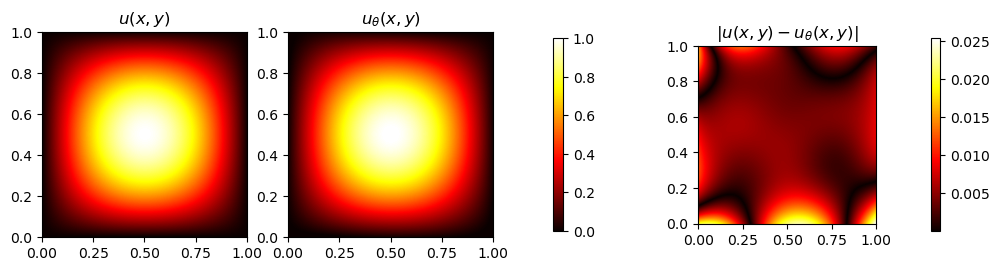

In [9]:
from util import save

n = 300
save("multiadam", n, u_star, v_model, params)